## -> Necessary Path Settings

In [1]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(".."))

### Function Monitor

In [2]:
import time
import tracemalloc

def timed_memory_profile(func, *args, **kwargs):
    tracemalloc.start()
    start_time = time.perf_counter()

    result = func(*args, **kwargs)

    end_time = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"Execution time: {end_time - start_time:.4f} seconds")
    print(f"Current memory usage: {current / 1024:.2f} KB")
    print(f"Peak memory usage: {peak / 1024:.2f} KB")

    return result


### Static constants to load once

In [3]:
from nltk.corpus import stopwords, wordnet as wn
from src.services import (
    extract_top_n_nouns_with_frequency,
    get_sentences_with_target_word
)

STOP_WORDS = set(stopwords.words("english"))
ALL_NOUNS = {lemma.name().lower() for synset in wn.all_synsets(wn.NOUN) for lemma in synset.lemmas()}

## -> Book upload and text convert

### Example 1: Psychology book

In [4]:
with open('../test_pdfs/req_compressed.txt') as f:
    text_content = f.read()

print(len(text_content))

4473723


## -> Noun Extraction with frequency

In [5]:
extract_top_n_nouns_with_frequency(text_content, 50, STOP_WORDS, ALL_NOUNS)

{'system': 6250,
 'data': 4910,
 'software': 2954,
 'user': 2700,
 'specification': 2311,
 'page': 1843,
 'information': 1658,
 'time': 1620,
 'use': 1543,
 'interface': 1465,
 'control': 1373,
 'number': 1182,
 'status': 1179,
 'version': 1044,
 'description': 939,
 'section': 913,
 'document': 904,
 'application': 862,
 'file': 854,
 'access': 839,
 'service': 833,
 'case': 819,
 'type': 811,
 'call': 762,
 'requirement': 750,
 'network': 742,
 'message': 741,
 'project': 737,
 'product': 727,
 'name': 722,
 'level': 682,
 'management': 667,
 'services': 658,
 'item': 622,
 'date': 619,
 'output': 612,
 'design': 597,
 'operator': 582,
 'group': 581,
 'list': 580,
 'radio': 570,
 'process': 547,
 'function': 537,
 'operation': 525,
 'input': 519,
 'state': 515,
 'id': 509,
 'temperature': 509,
 'command': 508,
 'mode': 504}

## -> Sentence Extraction with target word

In [6]:
# target word
target_word = 'system'

sentences = get_sentences_with_target_word(text_content, target_word, 1000)

Truncated sentence to 444 tokens: BOOKMARK NOT DE vi Acronym List ADRG ADT AFATDS AFMSS AIS AMPS ASAS ASD ATCSS ATHS ATO ATWCS AV BITE...
Truncated sentence to 463 tokens: TCS - C4I Interface Design Description Tactical Control System (TCS) to Army Mission Planning System...
Truncated sentence to 350 tokens: I-15 Reversible Lane Control System Level 1 - Data Flow April 21, 2004 Section VID page 45 of 66 Dep...
Truncated sentence to 460 tokens: RF connector intended primarily for analogue speech’ IEC 1508 ‘Functional safety: Safety related sys...
Truncated sentence to 477 tokens: ADA A-DCS AFWA API APS ATMS AWIPS C1 C2 C3 C3S CASE CDR CDR CE CLASS CM CMIS CO CONOPS COOP COR COTS...
Truncated sentence to 453 tokens: ESPC is able to The Contractor plan for new shall support systems, and for technical planning change...
Truncated sentence to 394 tokens: These Operation Types are: • Data operation to capture and deliver formatted ELSS data for transmiss...


In [7]:
len(sentences)

1000

In [8]:
sentences[98]

'the system shall utilize consistent symbols and colors for clear notifications'

## -> Similarity Matrix Generation

In [9]:
import torch
from transformers import BertModel, BertTokenizer
from src.models import DisambModel 

# Load model & tokenizer
bert_model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DisambModel(bert_model, bert_tokenizer, device)


In [10]:
from src.services import compute_cosine_similarity_matrix

sim_matrix, sentences_embeddings = compute_cosine_similarity_matrix(
    sentences=sentences,
    target_word=target_word,
    model=model
)

In [11]:
sentences_embeddings[0].shape

torch.Size([768])

In [12]:
sim_matrix.shape

torch.Size([1000, 1000])

## -> Finding Optimal number of clusters from similarity matrix (by using elbow method)

In [13]:
from src.services import suggest_num_clusters_with_data

optimal_k, k_range, wcss = suggest_num_clusters_with_data(sim_matrix)

print("Optimal cluster count in range [1, 10]: ", optimal_k)

Optimal cluster count in range [1, 10]:  4


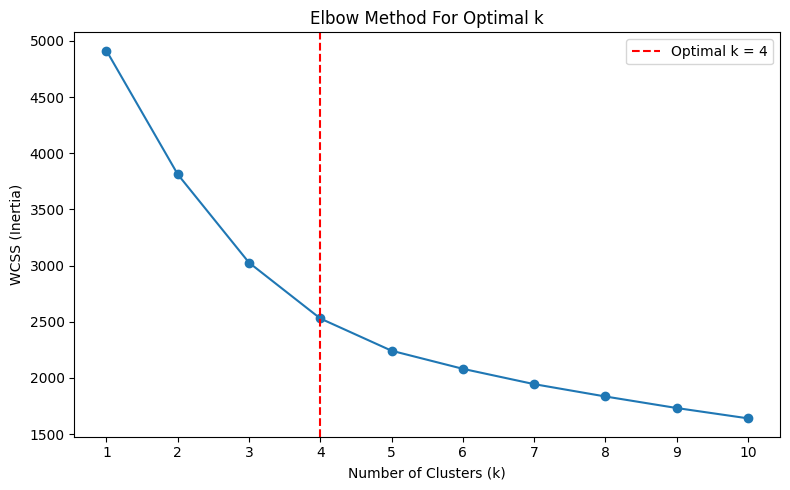

In [14]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)

# Annotate the optimal k
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

## -> Label Sentences by cluster

In [15]:
from src.services import label_sentences_by_cluster

clusters_dict = label_sentences_by_cluster(sentences, sim_matrix, optimal_k)

In [18]:
from src.services import generate_summary_files
from pathlib import Path
from random import random

generate_summary_files(
    target_word=target_word,
    clusters_dict=clusters_dict,
    summary_folder_path=Path(str(random())),
    disamb_model=model
)